In [163]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [180]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate = 0.00001
        self.epochs = 100
        self.batch_size = 100
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.2  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        # calc feature-wise mean
        if mean is None:
            mean = np.mean(x, axis=0)
            
        # calc feature-wise std
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x_norm = x - mean

        # div by the standard dev.
        x_norm = x_norm / std

        return x_norm, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train    
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], 1))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], 1))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector
        
        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        residual = np.linalg.norm(pred_y - yt_sm, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.square( np.linalg.norm(self.weights, ord=2, axis=0) )
    
        return loss 
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        
        n_samples = x.shape[0]  
        
        # need to add the mean back to label
        yt = yt_sm + self.y_mean
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # need to add the y mean back
        pred_y = pred_y + self.y_mean
        
        residual = np.linalg.norm(pred_y - yt, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.square( np.linalg.norm(self.weights, ord=2, axis=0) )
    
        return loss
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]
        
        pred_y = np.dot(x, self.weights)
        residual = pred_y - yt_sm
        dW = 2 * (np.dot(x.T, residual) / n_samples) + 2 * self.weights * self.alpha
        
        return dW

    def calc_mse(self, x, y_sm):
        # preprocesses (adds the y_mean back to both x and y, and calls musicMSE)
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred and convert to int to round
        pred_y += self.y_mean
        
        # convert to int to round
        pred_y = pred_y.astype(int)
        
        # add the y mean back to the labels
        y_labels = y_sm + self.y_mean
        
        # convert to int to round
        y_labels = y_labels.astype(int)
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        print('MSE: ', mse)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            
#             print('weights: ', self.weights)
            
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_mse_arr = []
        test_mse_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_mse, train_preds = self.calc_mse(x_train, y_train_sm)
            test_mse, test_preds = self.calc_mse(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_mse_arr.append(train_mse)
            test_mse_arr.append(test_mse)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds

    def closed_form(self, x, yt):
        # yt is regular labels
        # returns the weights w that allow you to find the prediction

        xt = np.transpose(x)
        alpha_identity = self.alpha * np.identity(len(xt))

        theInverse = np.linalg.inv(np.dot(xt, x) + alpha_identity)
        w = np.dot(np.dot(theInverse, xt), yt)
        return w
    
    
    def plot_graph(self, train_losses, test_losses, train_mse, test_mse):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Ridge Regression: Loss vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_mse, label="Train MSE")
        plt.plot(test_mse, label="Test MSE")
        plt.legend(loc='best')
        plt.title("Ridge Regression: MSE vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()
        # save plot 
#         plt.savefig('./regression_loss_acc')

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()
        
    def plot_weights(self):
        
        plt.hist(self.weights, bins=12)
        plt.xlabel('bins')
        plt.ylabel('count')
        plt.title('Ridge Regression Weights Histogram')
        plt.show()



In [165]:
# create Regression() object to load data
regr = Regression()

In [166]:
# # # load the data
# fname = 'YearPredictionMSD.txt'
# x_train, y_train, x_test, y_test = regr.load_data(fname)

In [183]:
# discuss the properties of the data
x_min = np.min(x_train)
x_max = np.max(x_train)

y_min = np.min(y_train)
y_max = np.max(y_train)


# the range of the x feature values is huge, we from -14,000 to 65,000, with a wide
# range in scales too, from 1000s to decimals, so we'll need to normalize

# for the y labels, it's in years, from 1922-2011, and roughly the same in the test,
# though slightly wider range.

# The 90's and 2000's are much more over represented than the rest of the 
# years, expecially the earlier you get.

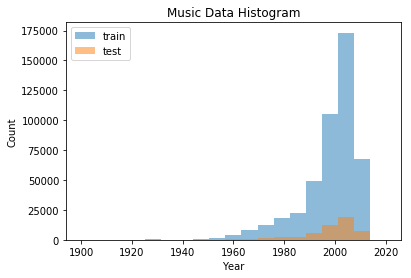

In [190]:
bins = np.linspace(1900, 2020, 20)

plt.hist(y_train, bins, alpha=0.5, label='train')
plt.hist(y_test, bins, alpha=0.5, label='test')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Music Data Histogram')
plt.legend(loc='upper left')
plt.show()

In [185]:
#  find the most common year (in test data)

years_arr, count = np.unique(y_test, return_counts=True)
year_count_dict = dict(zip(years_arr, count))
# year_count_dict

In [186]:
# find the loss if every prediction is most commmon 
n_samples = x_train.shape[0]
most_common_year = 2007
common_pred = np.full((n_samples, 1), most_common_year)

In [187]:
most_common_loss = regr.musicMSE(common_pred, y_train)
most_common_loss
#  most common year loss = 193.87

193.87802179791854

In [188]:
# find loss for 1998
n_samples = x_train.shape[0]
most_common_year = 1998
common_pred = np.full((n_samples, 1), most_common_year)


In [189]:
loss_1998 = regr.musicMSE(common_pred, y_train)
loss_1998
#  1998 year loss = 119.82

119.82739576549339

In [174]:
# ==========  Ridge Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 100...
MSE:  113.81411171541079
MSE:  112.15165307664
Epoch 2 / 100...
MSE:  110.11232785725684
MSE:  108.49061610272898
Epoch 3 / 100...
MSE:  107.7550537615858
MSE:  106.22333481822936
Epoch 4 / 100...
MSE:  105.98050522520347
MSE:  104.54403362321086
Epoch 5 / 100...
MSE:  104.63907494705788
MSE:  103.23935232709032
Epoch 6 / 100...
MSE:  103.5315992184838
MSE:  102.24574383606748
Epoch 7 / 100...
MSE:  102.64217815291322
MSE:  101.34277856326625
Epoch 8 / 100...
MSE:  101.8852180438805
MSE:  100.58127868915962
Epoch 9 / 100...
MSE:  101.219268773425
MSE:  99.96918517944646
Epoch 10 / 100...
MSE:  100.64723299274984
MSE:  99.42987739923689
Epoch 11 / 100...
MSE:  100.15098099259457
MSE:  98.96108926807538
Epoch 12 / 100...
MSE:  99.71087135605136
MSE:  98.5934806608433
Epoch 13 / 100...
MSE:  99.3320106789961
MSE:  98.24901706339215
Epoch 14 / 100...
MSE:  98.97008500929452
MSE:  97.89785206561949
Epoch 15 / 100...
MSE:  98.64776349215249
MSE:  97.56179427088377
Epoch 16 /

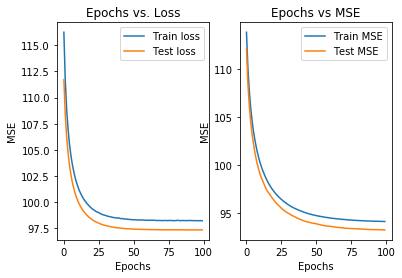

<Figure size 432x288 with 0 Axes>

In [181]:
# plot loss and accuracies graphs

regr.plot_graph(train_losses, test_losses, train_mse_arr, test_mse_arr)

In [176]:
# closed form solution to ridge regression, obtain w from training data
w_closed_form = regr.closed_form(x_train, y_train)

# apply w to test data
y_pred = np.dot(x_test, w_closed_form)

# calc MSE 
mse_closed_form = regr.musicMSE(y_pred, y_test)
mse_closed_form

90.44342442377375

In [177]:
# Compared to the low of ~93 for the iterative solution I got, the closed form is much lower.


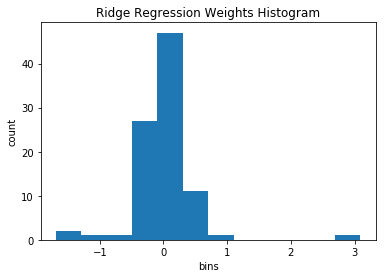

In [178]:
# plot the weights
regr.plot_weights()

In [179]:
y_pred

array([[1996.86316457],
       [1994.88400408],
       [2002.62592175],
       ...,
       [1996.98506823],
       [2001.89154874],
       [1999.71070333]])